## Requirements and Imports


In [1]:
import copy
import os
from pathlib import Path
from itertools import combinations
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from torch.utils.data import TensorDataset, DataLoader , WeightedRandomSampler

from sklearn.metrics import roc_auc_score , pairwise_distances
import torch
import torch.optim as optim
import scipy.sparse as sp
from numba import jit
import squidpy as sq
import models
from sklearn.metrics import accuracy_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [2]:
adata = sq.datasets.merfish()
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
adata


AnnData object with n_obs × n_vars = 73642 × 161
    obs: 'Cell_ID', 'Animal_ID', 'Animal_sex', 'Behavior', 'Bregma', 'Centroid_X', 'Centroid_Y', 'Cell_class', 'Neuron_cluster_ID', 'batch', 'n_counts'
    uns: 'Cell_class_colors', 'log1p'
    obsm: 'spatial', 'spatial3d'

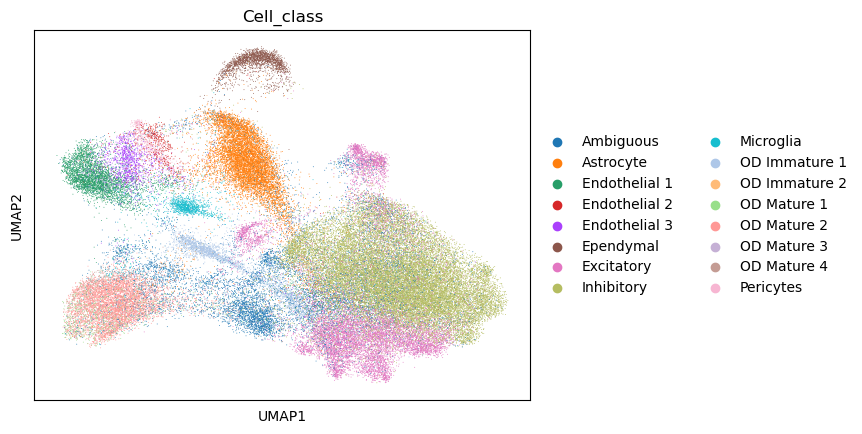

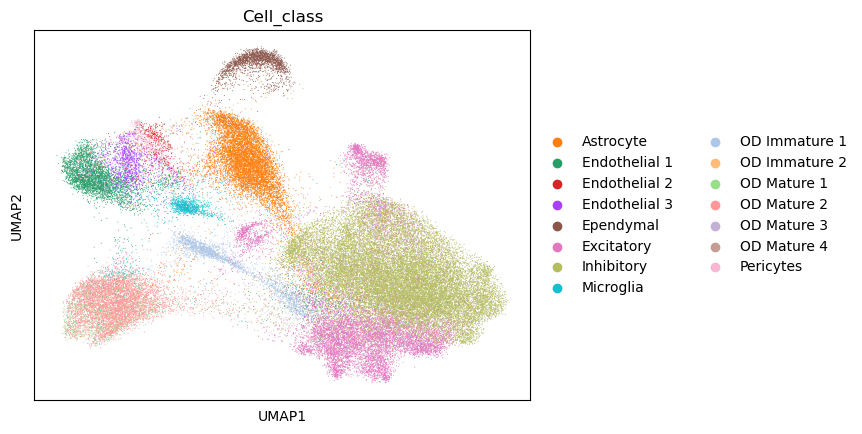

/cs/labs/mornitzan/karinjo/miniconda/envs/rev08/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


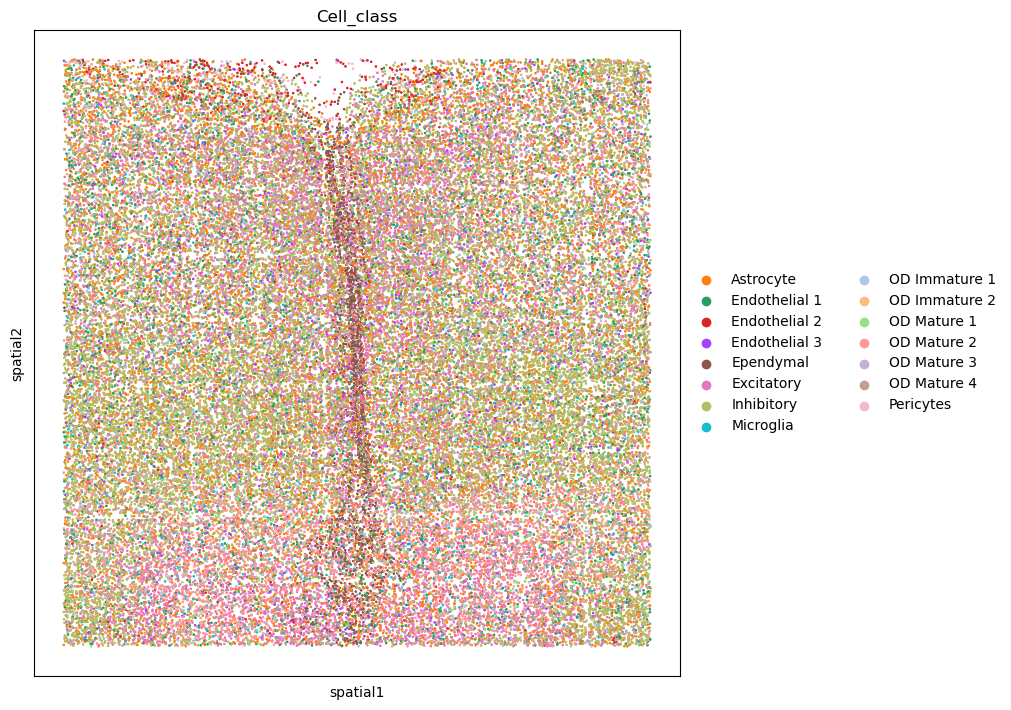

In [3]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='Cell_class')
adata= adata[adata.obs['Cell_class'].isin(['OD Mature 2',
 'OD Immature 1',
 'Inhibitory',
 'Excitatory',
 'Microglia',
 'Astrocyte',
 'Endothelial 2',
 'Endothelial 3',
 'Endothelial 1',
 'OD Mature 1',
 'OD Mature 4',
 'Pericytes',
 'OD Mature 3',
 'Ependymal',
 'OD Immature 2']
)]
sc.pl.umap(adata,color='Cell_class')
sq.pl.spatial_scatter(
    adata, color="Cell_class", shape=None, figsize=(10, 10)
)


In [4]:
import numpy as np

# Define a dictionary to map each cluster to its corresponding cell type
cell_type_mapping = {
    'OD Mature 2': 'OD Mature',
    'OD Immature 1': 'OD Immature',
    'Inhibitory': 'Inhibitory',
    'Excitatory': 'Excitatory',
    'Microglia': 'Microglia',
    'Astrocyte': 'Astrocyte',
    'Endothelial 2': 'Endothelial',
    'Endothelial 3': 'Endothelial',
    'Endothelial 1': 'Endothelial',
    'OD Mature 1': 'OD Mature',
    'OD Mature 4': 'OD Mature',
    'Pericytes': 'Pericytes',
    'OD Mature 3': 'OD Mature',
    'Ependymal': 'Ependymal',
    'OD Immature 2': 'OD Immature'
}

# Create an empty list to store the updated cell types
cell_type_list = []

# Iterate over each cluster and assign the corresponding cell type
for i in range(adata.n_obs):
    cluster_name = adata.obs['Cell_class'][i]
    if cluster_name in cell_type_mapping:
        cell_type_list.append(cell_type_mapping[cluster_name])
    else:
        cell_type_list.append(cluster_name)

# Update the cell type column in the AnnData object
adata.obs['CellType'] = np.array(cell_type_list)


In [5]:
import random
import pandas as pd

def modify_labels(orig_labeles, probability=0.1):
    # Get the list of all possible labels
    all_labels = list(set(orig_labeles))

    # Create a list to store the modified labels
    modified_labels = []

    # Loop over the labels in the dataset
    for label in orig_labeles:
        # Generate a random number between 0 and 1
        r = random.random()

        # If the random number is smaller than the probability,
        # modify the label by choosing a random label from the list of all labels,
        # excluding the original label
        if r < probability:
            modified_label = random.choice([l for l in all_labels if l != label])
        else:
            modified_label = label

        # Add the modified label to the list
        modified_labels.append(modified_label)

    # Create a DataFrame with the original and modified labels
    df = pd.DataFrame({"label": orig_labeles, "modified_label": modified_labels})


    return df , (np.where(df["label"] != df["modified_label"]))

def one_hot_encode(labels):
    """
    One-hot encodes an array of labels.
    
    Args:
        labels (numpy.ndarray): Array of labels.
        
    Returns:
        tuple: One-hot encoded array of labels, and a label encoder.
    """
    values = np.array(labels)
    print(values)
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    print(integer_encoded)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # invert first example
    inverted = label_encoder.inverse_transform([np.argmax(onehot_encoded[0, :])])
    return onehot_encoded, label_encoder



In [6]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier


def multi_ada_sampling(data, label, classifier="svm", percent=1, L=10, prob_output=False, balance=True, iter=3):
    def update_xy(vote_class, label, percent, balance):
        sample_size = int(np.round(np.median(list(Counter(label).values()))))
        idx = []
        if balance:
            idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        else:
            if len(vote_class) > sample_size:
                idx = resample(np.arange(len(vote_class)), n_samples=int(sample_size * percent), replace=True, stratify=vote_class)
            else:
                idx = resample(np.arange(len(vote_class)), n_samples=int(len(vote_class) * percent), replace=True, stratify=vote_class)
        
        return data[:, idx], label[idx]

    models = []
    for _ in range(L):
        X = data
        Y = label
        model_list = []
        prob_list = []
        
        for _ in range(iter):
            if classifier == "rf":
                model = RandomForestClassifier(n_estimators=100)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier == "svm":
                model = SVC(probability=True)
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
            elif classifier =="knn":
                model = KNeighborsClassifier()
                model.fit(X.T, Y)
                prob = model.predict_proba(data.T)
                #print(prob)
            else:
                raise ValueError(f"Unknown classifier: {classifier}")
            
            X, Y = [], []
            xy_update = []
            for j in range(prob.shape[1]):
                vote_class = prob[label == j]
                xy_update.append(update_xy(vote_class, label, percent, balance))
            
            cur_X = np.column_stack([xy[0] for xy in xy_update])
            cur_Y = np.concatenate([xy[1] for xy in xy_update])
            X, Y = cur_X, cur_Y
        models.append(model)
    
    predict_mat = np.zeros((data.shape[1], len(np.unique(label))))
    final = []
    for model in models:
        if classifier == "svm":
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        else:
            tmp = model.predict_proba(data.T)[:, list(np.unique(label))]
        predict_mat += tmp
    
    if prob_output:
        final = np.max(predict_mat, axis=1)
        final = dict(zip(list(np.unique(label))[np.argmax(predict_mat, axis=1)], final))
    else:
        final = 0#list(np.unique(label))[np.argmax(predict_mat, axis=1)]
    
    return {"final": final, "models": models, "prob": predict_mat}

def get_conf_from_scReClassify(adata, res , formerlabels, L=10):
    prob_mat= res['prob']
    return prob_mat[np.arange(len(prob_mat)), formerlabels]/L



In [7]:
adata_copy = adata.copy()


In [8]:
from sklearn.preprocessing import LabelEncoder
epoch_num=20



from sklearn.preprocessing import LabelEncoder
screc_res_list_rf = []
screc_res_list_svm = []
screc_res_list_knn = []
cell_anno_list = []
screc_res_list_rf_var = []
screc_res_list_knn_var = []
screc_res_list_svm_var = []
cell_anno_list_var = []
for i in range(1,6):
    tmp_roc_screc_rf = []
    tmp_roc_screc_knn = []
    tmp_roc_screc_svm = []
    tmp_roc_cell_anno = []
    for j in range(10):
        adata= adata_copy.copy()
        sc.pp.subsample(adata, n_obs=10000)
        labeles = adata.obs['CellType']
        df , were_changed = modify_labels(labeles , probability=0.1*i)
        were_changed_array =np.zeros(adata.n_obs)
        were_changed_array[were_changed]=1
        adata.obs['former_labels']=df['label']
        adata.obs['new_labels']=df['modified_label']
        adata.obs['new_labels']
        le = LabelEncoder()
        le.fit(adata.obs['new_labels'])

        mod_labels= le.transform(adata.obs['new_labels'])
        former_labels= le.transform(adata.obs['former_labels'])
        
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="knn")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_knn.append(roc_auc_score(1-were_changed_array, conf))

        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="rf")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_rf.append(roc_auc_score(1-were_changed_array, conf))
        res = multi_ada_sampling(adata.obsm['X_pca'].T,mod_labels, classifier="svm")
        conf = get_conf_from_scReClassify(adata,res,mod_labels)
        tmp_roc_screc_svm.append(roc_auc_score(1-were_changed_array, conf))
        prob_list = models.follow_training_dyn_neural_net(adata, label_key='new_labels',iterNum=epoch_num, device=device, batch_size=64)
        all_conf , all_var = models.probability_list_to_confidence_and_var(prob_list, n_obs= adata.n_obs, epoch_num=epoch_num)
        tmp_roc_cell_anno.append(roc_auc_score(1-were_changed_array, all_conf))
        print(tmp_roc_screc_knn)
        print(tmp_roc_screc_rf)
        print(tmp_roc_screc_svm)
        print(tmp_roc_cell_anno)
    screc_res_list_knn.append(np.mean(tmp_roc_screc_knn))
    screc_res_list_rf.append(np.mean(tmp_roc_screc_rf))
    screc_res_list_svm.append(np.mean(tmp_roc_screc_svm))
    cell_anno_list.append(np.mean(tmp_roc_cell_anno))
    screc_res_list_rf_var.append(np.var(tmp_roc_screc_rf))
    screc_res_list_svm_var.append(np.var(tmp_roc_screc_svm))
    cell_anno_list_var.append(np.var(tmp_roc_cell_anno))
    screc_res_list_knn_var.append(np.var(tmp_roc_screc_knn))



/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.442
[1,    12] loss: 2.205
[1,    22] loss: 2.179
[1,    32] loss: 2.155
[1,    42] loss: 2.137
[1,    52] loss: 2.127
[1,    62] loss: 2.097
[1,    72] loss: 2.067
[1,    82] loss: 2.056
[1,    92] loss: 2.030
[1,   102] loss: 1.992
[1,   112] loss: 1.957
[1,   122] loss: 1.947
[1,   132] loss: 1.880
[1,   142] loss: 1.839
[1,   152] loss: 1.808
[2,     2] loss: 0.350
[2,    12] loss: 1.775
[2,    22] loss: 1.672
[2,    32] loss: 1.726
[2,    42] loss: 1.654
[2,    52] loss: 1.615
[2,    62] loss: 1.560
[2,    72] loss: 1.555
[2,    82] loss: 1.549
[2,    92] loss: 1.458
[2,   102] loss: 1.467
[2,   112] loss: 1.452
[2,   122] loss: 1.432
[2,   132] loss: 1.316
[2,   142] loss: 1.347
[2,   152] loss: 1.317
[3,     2] loss: 0.258
[3,    12] loss: 1.318
[3,    22] loss: 1.250
[3,    32] loss: 1.268
[3,    42] loss: 1.328
[3,    52] loss: 1.311
[3,    62] loss: 1.284
[3,    72] loss: 1.226
[3,    82] loss: 1.239
[3,    92] loss: 1.265
[3,   102] loss: 1.208
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.444
[1,    12] loss: 2.213
[1,    22] loss: 2.189
[1,    32] loss: 2.156
[1,    42] loss: 2.131
[1,    52] loss: 2.091
[1,    62] loss: 2.070
[1,    72] loss: 2.032
[1,    82] loss: 2.000
[1,    92] loss: 1.969
[1,   102] loss: 1.927
[1,   112] loss: 1.903
[1,   122] loss: 1.891
[1,   132] loss: 1.806
[1,   142] loss: 1.751
[1,   152] loss: 1.723
[2,     2] loss: 0.335
[2,    12] loss: 1.644
[2,    22] loss: 1.662
[2,    32] loss: 1.576
[2,    42] loss: 1.590
[2,    52] loss: 1.491
[2,    62] loss: 1.490
[2,    72] loss: 1.458
[2,    82] loss: 1.382
[2,    92] loss: 1.423
[2,   102] loss: 1.362
[2,   112] loss: 1.352
[2,   122] loss: 1.338
[2,   132] loss: 1.267
[2,   142] loss: 1.299
[2,   152] loss: 1.268
[3,     2] loss: 0.269
[3,    12] loss: 1.261
[3,    22] loss: 1.246
[3,    32] loss: 1.125
[3,    42] loss: 1.188
[3,    52] loss: 1.211
[3,    62] loss: 1.220
[3,    72] loss: 1.202
[3,    82] loss: 1.147
[3,    92] loss: 1.193
[3,   102] loss: 1.205
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.444
[1,    12] loss: 2.198
[1,    22] loss: 2.186
[1,    32] loss: 2.162
[1,    42] loss: 2.164
[1,    52] loss: 2.117
[1,    62] loss: 2.110
[1,    72] loss: 2.075
[1,    82] loss: 2.069
[1,    92] loss: 2.033
[1,   102] loss: 1.993
[1,   112] loss: 1.963
[1,   122] loss: 1.943
[1,   132] loss: 1.891
[1,   142] loss: 1.877
[1,   152] loss: 1.811
[2,     2] loss: 0.345
[2,    12] loss: 1.728
[2,    22] loss: 1.715
[2,    32] loss: 1.724
[2,    42] loss: 1.677
[2,    52] loss: 1.612
[2,    62] loss: 1.559
[2,    72] loss: 1.474
[2,    82] loss: 1.505
[2,    92] loss: 1.422
[2,   102] loss: 1.424
[2,   112] loss: 1.370
[2,   122] loss: 1.377
[2,   132] loss: 1.406
[2,   142] loss: 1.359
[2,   152] loss: 1.299
[3,     2] loss: 0.238
[3,    12] loss: 1.262
[3,    22] loss: 1.348
[3,    32] loss: 1.250
[3,    42] loss: 1.263
[3,    52] loss: 1.242
[3,    62] loss: 1.129
[3,    72] loss: 1.171
[3,    82] loss: 1.184
[3,    92] loss: 1.177
[3,   102] loss: 1.054
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.453
[1,    12] loss: 2.228
[1,    22] loss: 2.218
[1,    32] loss: 2.194
[1,    42] loss: 2.174
[1,    52] loss: 2.143
[1,    62] loss: 2.127
[1,    72] loss: 2.102
[1,    82] loss: 2.096
[1,    92] loss: 2.066
[1,   102] loss: 2.048
[1,   112] loss: 2.018
[1,   122] loss: 1.972
[1,   132] loss: 1.949
[1,   142] loss: 1.907
[1,   152] loss: 1.875
[2,     2] loss: 0.369
[2,    12] loss: 1.822
[2,    22] loss: 1.805
[2,    32] loss: 1.757
[2,    42] loss: 1.686
[2,    52] loss: 1.631
[2,    62] loss: 1.610
[2,    72] loss: 1.620
[2,    82] loss: 1.485
[2,    92] loss: 1.456
[2,   102] loss: 1.516
[2,   112] loss: 1.414
[2,   122] loss: 1.449
[2,   132] loss: 1.418
[2,   142] loss: 1.401
[2,   152] loss: 1.316
[3,     2] loss: 0.280
[3,    12] loss: 1.390
[3,    22] loss: 1.312
[3,    32] loss: 1.277
[3,    42] loss: 1.291
[3,    52] loss: 1.202
[3,    62] loss: 1.331
[3,    72] loss: 1.224
[3,    82] loss: 1.286
[3,    92] loss: 1.258
[3,   102] loss: 1.227
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.173
[1,    22] loss: 2.173
[1,    32] loss: 2.132
[1,    42] loss: 2.115
[1,    52] loss: 2.100
[1,    62] loss: 2.073
[1,    72] loss: 2.048
[1,    82] loss: 1.995
[1,    92] loss: 1.992
[1,   102] loss: 1.970
[1,   112] loss: 1.900
[1,   122] loss: 1.884
[1,   132] loss: 1.818
[1,   142] loss: 1.779
[1,   152] loss: 1.759
[2,     2] loss: 0.332
[2,    12] loss: 1.715
[2,    22] loss: 1.580
[2,    32] loss: 1.623
[2,    42] loss: 1.550
[2,    52] loss: 1.545
[2,    62] loss: 1.497
[2,    72] loss: 1.505
[2,    82] loss: 1.478
[2,    92] loss: 1.412
[2,   102] loss: 1.467
[2,   112] loss: 1.358
[2,   122] loss: 1.436
[2,   132] loss: 1.356
[2,   142] loss: 1.322
[2,   152] loss: 1.313
[3,     2] loss: 0.293
[3,    12] loss: 1.309
[3,    22] loss: 1.310
[3,    32] loss: 1.244
[3,    42] loss: 1.278
[3,    52] loss: 1.190
[3,    62] loss: 1.204
[3,    72] loss: 1.224
[3,    82] loss: 1.241
[3,    92] loss: 1.195
[3,   102] loss: 1.351
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.443
[1,    12] loss: 2.224
[1,    22] loss: 2.208
[1,    32] loss: 2.206
[1,    42] loss: 2.170
[1,    52] loss: 2.159
[1,    62] loss: 2.122
[1,    72] loss: 2.113
[1,    82] loss: 2.088
[1,    92] loss: 2.061
[1,   102] loss: 2.033
[1,   112] loss: 2.012
[1,   122] loss: 1.979
[1,   132] loss: 1.922
[1,   142] loss: 1.895
[1,   152] loss: 1.895
[2,     2] loss: 0.377
[2,    12] loss: 1.787
[2,    22] loss: 1.812
[2,    32] loss: 1.696
[2,    42] loss: 1.668
[2,    52] loss: 1.631
[2,    62] loss: 1.585
[2,    72] loss: 1.578
[2,    82] loss: 1.555
[2,    92] loss: 1.521
[2,   102] loss: 1.503
[2,   112] loss: 1.426
[2,   122] loss: 1.377
[2,   132] loss: 1.323
[2,   142] loss: 1.371
[2,   152] loss: 1.323
[3,     2] loss: 0.253
[3,    12] loss: 1.280
[3,    22] loss: 1.291
[3,    32] loss: 1.223
[3,    42] loss: 1.240
[3,    52] loss: 1.356
[3,    62] loss: 1.257
[3,    72] loss: 1.237
[3,    82] loss: 1.227
[3,    92] loss: 1.162
[3,   102] loss: 1.208
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.457
[1,    12] loss: 2.243
[1,    22] loss: 2.191
[1,    32] loss: 2.147
[1,    42] loss: 2.095
[1,    52] loss: 2.069
[1,    62] loss: 2.054
[1,    72] loss: 2.003
[1,    82] loss: 1.978
[1,    92] loss: 1.949
[1,   102] loss: 1.902
[1,   112] loss: 1.863
[1,   122] loss: 1.843
[1,   132] loss: 1.786
[1,   142] loss: 1.786
[1,   152] loss: 1.743
[2,     2] loss: 0.339
[2,    12] loss: 1.641
[2,    22] loss: 1.580
[2,    32] loss: 1.534
[2,    42] loss: 1.562
[2,    52] loss: 1.447
[2,    62] loss: 1.425
[2,    72] loss: 1.429
[2,    82] loss: 1.328
[2,    92] loss: 1.333
[2,   102] loss: 1.274
[2,   112] loss: 1.322
[2,   122] loss: 1.306
[2,   132] loss: 1.355
[2,   142] loss: 1.346
[2,   152] loss: 1.219
[3,     2] loss: 0.246
[3,    12] loss: 1.210
[3,    22] loss: 1.205
[3,    32] loss: 1.189
[3,    42] loss: 1.212
[3,    52] loss: 1.120
[3,    62] loss: 1.232
[3,    72] loss: 1.190
[3,    82] loss: 1.172
[3,    92] loss: 1.164
[3,   102] loss: 1.176
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.437
[1,    12] loss: 2.233
[1,    22] loss: 2.206
[1,    32] loss: 2.175
[1,    42] loss: 2.160
[1,    52] loss: 2.134
[1,    62] loss: 2.114
[1,    72] loss: 2.086
[1,    82] loss: 2.076
[1,    92] loss: 2.040
[1,   102] loss: 2.014
[1,   112] loss: 2.010
[1,   122] loss: 1.975
[1,   132] loss: 1.897
[1,   142] loss: 1.900
[1,   152] loss: 1.835
[2,     2] loss: 0.362
[2,    12] loss: 1.744
[2,    22] loss: 1.749
[2,    32] loss: 1.663
[2,    42] loss: 1.666
[2,    52] loss: 1.627
[2,    62] loss: 1.595
[2,    72] loss: 1.554
[2,    82] loss: 1.512
[2,    92] loss: 1.474
[2,   102] loss: 1.449
[2,   112] loss: 1.413
[2,   122] loss: 1.393
[2,   132] loss: 1.414
[2,   142] loss: 1.369
[2,   152] loss: 1.318
[3,     2] loss: 0.246
[3,    12] loss: 1.250
[3,    22] loss: 1.327
[3,    32] loss: 1.245
[3,    42] loss: 1.276
[3,    52] loss: 1.290
[3,    62] loss: 1.160
[3,    72] loss: 1.327
[3,    82] loss: 1.129
[3,    92] loss: 1.133
[3,   102] loss: 1.237
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.446
[1,    12] loss: 2.253
[1,    22] loss: 2.213
[1,    32] loss: 2.207
[1,    42] loss: 2.143
[1,    52] loss: 2.138
[1,    62] loss: 2.104
[1,    72] loss: 2.087
[1,    82] loss: 2.081
[1,    92] loss: 2.055
[1,   102] loss: 2.001
[1,   112] loss: 1.957
[1,   122] loss: 1.925
[1,   132] loss: 1.887
[1,   142] loss: 1.844
[1,   152] loss: 1.801
[2,     2] loss: 0.352
[2,    12] loss: 1.766
[2,    22] loss: 1.656
[2,    32] loss: 1.639
[2,    42] loss: 1.599
[2,    52] loss: 1.575
[2,    62] loss: 1.569
[2,    72] loss: 1.469
[2,    82] loss: 1.514
[2,    92] loss: 1.482
[2,   102] loss: 1.435
[2,   112] loss: 1.416
[2,   122] loss: 1.433
[2,   132] loss: 1.256
[2,   142] loss: 1.243
[2,   152] loss: 1.389
[3,     2] loss: 0.281
[3,    12] loss: 1.254
[3,    22] loss: 1.312
[3,    32] loss: 1.176
[3,    42] loss: 1.191
[3,    52] loss: 1.184
[3,    62] loss: 1.204
[3,    72] loss: 1.299
[3,    82] loss: 1.182
[3,    92] loss: 1.282
[3,   102] loss: 1.151
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.205
[1,    22] loss: 2.176
[1,    32] loss: 2.163
[1,    42] loss: 2.127
[1,    52] loss: 2.092
[1,    62] loss: 2.082
[1,    72] loss: 2.072
[1,    82] loss: 2.015
[1,    92] loss: 1.987
[1,   102] loss: 1.966
[1,   112] loss: 1.930
[1,   122] loss: 1.881
[1,   132] loss: 1.831
[1,   142] loss: 1.787
[1,   152] loss: 1.750
[2,     2] loss: 0.343
[2,    12] loss: 1.678
[2,    22] loss: 1.625
[2,    32] loss: 1.600
[2,    42] loss: 1.524
[2,    52] loss: 1.471
[2,    62] loss: 1.414
[2,    72] loss: 1.467
[2,    82] loss: 1.376
[2,    92] loss: 1.387
[2,   102] loss: 1.379
[2,   112] loss: 1.295
[2,   122] loss: 1.340
[2,   132] loss: 1.283
[2,   142] loss: 1.279
[2,   152] loss: 1.251
[3,     2] loss: 0.274
[3,    12] loss: 1.343
[3,    22] loss: 1.272
[3,    32] loss: 1.234
[3,    42] loss: 1.252
[3,    52] loss: 1.255
[3,    62] loss: 1.148
[3,    72] loss: 1.296
[3,    82] loss: 1.197
[3,    92] loss: 1.193
[3,   102] loss: 1.127
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.448
[1,    12] loss: 2.230
[1,    22] loss: 2.206
[1,    32] loss: 2.195
[1,    42] loss: 2.169
[1,    52] loss: 2.142
[1,    62] loss: 2.141
[1,    72] loss: 2.111
[1,    82] loss: 2.104
[1,    92] loss: 2.078
[1,   102] loss: 2.058
[1,   112] loss: 2.054
[1,   122] loss: 2.017
[1,   132] loss: 1.992
[1,   142] loss: 1.965
[1,   152] loss: 1.962
[2,     2] loss: 0.383
[2,    12] loss: 1.892
[2,    22] loss: 1.906
[2,    32] loss: 1.907
[2,    42] loss: 1.870
[2,    52] loss: 1.806
[2,    62] loss: 1.826
[2,    72] loss: 1.792
[2,    82] loss: 1.742
[2,    92] loss: 1.749
[2,   102] loss: 1.704
[2,   112] loss: 1.686
[2,   122] loss: 1.619
[2,   132] loss: 1.689
[2,   142] loss: 1.665
[2,   152] loss: 1.650
[3,     2] loss: 0.343
[3,    12] loss: 1.614
[3,    22] loss: 1.654
[3,    32] loss: 1.635
[3,    42] loss: 1.595
[3,    52] loss: 1.547
[3,    62] loss: 1.651
[3,    72] loss: 1.596
[3,    82] loss: 1.571
[3,    92] loss: 1.557
[3,   102] loss: 1.593
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.446
[1,    12] loss: 2.190
[1,    22] loss: 2.173
[1,    32] loss: 2.164
[1,    42] loss: 2.148
[1,    52] loss: 2.141
[1,    62] loss: 2.116
[1,    72] loss: 2.090
[1,    82] loss: 2.071
[1,    92] loss: 2.049
[1,   102] loss: 2.029
[1,   112] loss: 2.005
[1,   122] loss: 1.973
[1,   132] loss: 1.956
[1,   142] loss: 1.942
[1,   152] loss: 1.886
[2,     2] loss: 0.381
[2,    12] loss: 1.904
[2,    22] loss: 1.860
[2,    32] loss: 1.843
[2,    42] loss: 1.809
[2,    52] loss: 1.824
[2,    62] loss: 1.761
[2,    72] loss: 1.746
[2,    82] loss: 1.687
[2,    92] loss: 1.712
[2,   102] loss: 1.683
[2,   112] loss: 1.748
[2,   122] loss: 1.720
[2,   132] loss: 1.704
[2,   142] loss: 1.655
[2,   152] loss: 1.634
[3,     2] loss: 0.337
[3,    12] loss: 1.647
[3,    22] loss: 1.655
[3,    32] loss: 1.583
[3,    42] loss: 1.673
[3,    52] loss: 1.633
[3,    62] loss: 1.621
[3,    72] loss: 1.653
[3,    82] loss: 1.581
[3,    92] loss: 1.590
[3,   102] loss: 1.497
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.447
[1,    12] loss: 2.188
[1,    22] loss: 2.173
[1,    32] loss: 2.147
[1,    42] loss: 2.120
[1,    52] loss: 2.095
[1,    62] loss: 2.082
[1,    72] loss: 2.049
[1,    82] loss: 2.017
[1,    92] loss: 2.001
[1,   102] loss: 2.005
[1,   112] loss: 1.948
[1,   122] loss: 1.905
[1,   132] loss: 1.866
[1,   142] loss: 1.893
[1,   152] loss: 1.859
[2,     2] loss: 0.372
[2,    12] loss: 1.866
[2,    22] loss: 1.752
[2,    32] loss: 1.786
[2,    42] loss: 1.775
[2,    52] loss: 1.763
[2,    62] loss: 1.712
[2,    72] loss: 1.688
[2,    82] loss: 1.640
[2,    92] loss: 1.635
[2,   102] loss: 1.640
[2,   112] loss: 1.634
[2,   122] loss: 1.602
[2,   132] loss: 1.562
[2,   142] loss: 1.652
[2,   152] loss: 1.587
[3,     2] loss: 0.283
[3,    12] loss: 1.614
[3,    22] loss: 1.558
[3,    32] loss: 1.603
[3,    42] loss: 1.508
[3,    52] loss: 1.527
[3,    62] loss: 1.579
[3,    72] loss: 1.499
[3,    82] loss: 1.486
[3,    92] loss: 1.501
[3,   102] loss: 1.418
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.445
[1,    12] loss: 2.209
[1,    22] loss: 2.190
[1,    32] loss: 2.175
[1,    42] loss: 2.170
[1,    52] loss: 2.153
[1,    62] loss: 2.127
[1,    72] loss: 2.108
[1,    82] loss: 2.102
[1,    92] loss: 2.055
[1,   102] loss: 2.059
[1,   112] loss: 2.025
[1,   122] loss: 2.011
[1,   132] loss: 2.012
[1,   142] loss: 1.972
[1,   152] loss: 1.945
[2,     2] loss: 0.388
[2,    12] loss: 1.920
[2,    22] loss: 1.879
[2,    32] loss: 1.868
[2,    42] loss: 1.860
[2,    52] loss: 1.852
[2,    62] loss: 1.820
[2,    72] loss: 1.799
[2,    82] loss: 1.799
[2,    92] loss: 1.740
[2,   102] loss: 1.699
[2,   112] loss: 1.677
[2,   122] loss: 1.687
[2,   132] loss: 1.634
[2,   142] loss: 1.680
[2,   152] loss: 1.668
[3,     2] loss: 0.332
[3,    12] loss: 1.560
[3,    22] loss: 1.522
[3,    32] loss: 1.648
[3,    42] loss: 1.539
[3,    52] loss: 1.516
[3,    62] loss: 1.498
[3,    72] loss: 1.647
[3,    82] loss: 1.531
[3,    92] loss: 1.624
[3,   102] loss: 1.480
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.226
[1,    22] loss: 2.194
[1,    32] loss: 2.183
[1,    42] loss: 2.170
[1,    52] loss: 2.165
[1,    62] loss: 2.142
[1,    72] loss: 2.140
[1,    82] loss: 2.127
[1,    92] loss: 2.097
[1,   102] loss: 2.098
[1,   112] loss: 2.065
[1,   122] loss: 2.038
[1,   132] loss: 2.020
[1,   142] loss: 2.009
[1,   152] loss: 1.993
[2,     2] loss: 0.389
[2,    12] loss: 1.946
[2,    22] loss: 1.938
[2,    32] loss: 1.878
[2,    42] loss: 1.916
[2,    52] loss: 1.825
[2,    62] loss: 1.790
[2,    72] loss: 1.767
[2,    82] loss: 1.783
[2,    92] loss: 1.732
[2,   102] loss: 1.678
[2,   112] loss: 1.714
[2,   122] loss: 1.710
[2,   132] loss: 1.712
[2,   142] loss: 1.657
[2,   152] loss: 1.645
[3,     2] loss: 0.323
[3,    12] loss: 1.650
[3,    22] loss: 1.630
[3,    32] loss: 1.620
[3,    42] loss: 1.608
[3,    52] loss: 1.596
[3,    62] loss: 1.548
[3,    72] loss: 1.561
[3,    82] loss: 1.483
[3,    92] loss: 1.506
[3,   102] loss: 1.495
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.450
[1,    12] loss: 2.216
[1,    22] loss: 2.198
[1,    32] loss: 2.185
[1,    42] loss: 2.159
[1,    52] loss: 2.143
[1,    62] loss: 2.136
[1,    72] loss: 2.113
[1,    82] loss: 2.103
[1,    92] loss: 2.082
[1,   102] loss: 2.054
[1,   112] loss: 2.050
[1,   122] loss: 2.019
[1,   132] loss: 2.021
[1,   142] loss: 1.974
[1,   152] loss: 1.943
[2,     2] loss: 0.377
[2,    12] loss: 1.896
[2,    22] loss: 1.882
[2,    32] loss: 1.868
[2,    42] loss: 1.835
[2,    52] loss: 1.785
[2,    62] loss: 1.818
[2,    72] loss: 1.798
[2,    82] loss: 1.754
[2,    92] loss: 1.718
[2,   102] loss: 1.680
[2,   112] loss: 1.673
[2,   122] loss: 1.657
[2,   132] loss: 1.651
[2,   142] loss: 1.641
[2,   152] loss: 1.576
[3,     2] loss: 0.329
[3,    12] loss: 1.519
[3,    22] loss: 1.628
[3,    32] loss: 1.580
[3,    42] loss: 1.547
[3,    52] loss: 1.517
[3,    62] loss: 1.564
[3,    72] loss: 1.652
[3,    82] loss: 1.522
[3,    92] loss: 1.590
[3,   102] loss: 1.497
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.443
[1,    12] loss: 2.195
[1,    22] loss: 2.167
[1,    32] loss: 2.158
[1,    42] loss: 2.137
[1,    52] loss: 2.129
[1,    62] loss: 2.099
[1,    72] loss: 2.072
[1,    82] loss: 2.071
[1,    92] loss: 2.030
[1,   102] loss: 2.019
[1,   112] loss: 1.988
[1,   122] loss: 1.953
[1,   132] loss: 1.943
[1,   142] loss: 1.925
[1,   152] loss: 1.890
[2,     2] loss: 0.377
[2,    12] loss: 1.844
[2,    22] loss: 1.848
[2,    32] loss: 1.807
[2,    42] loss: 1.742
[2,    52] loss: 1.780
[2,    62] loss: 1.762
[2,    72] loss: 1.726
[2,    82] loss: 1.740
[2,    92] loss: 1.705
[2,   102] loss: 1.733
[2,   112] loss: 1.672
[2,   122] loss: 1.691
[2,   132] loss: 1.707
[2,   142] loss: 1.619
[2,   152] loss: 1.654
[3,     2] loss: 0.338
[3,    12] loss: 1.613
[3,    22] loss: 1.640
[3,    32] loss: 1.649
[3,    42] loss: 1.621
[3,    52] loss: 1.614
[3,    62] loss: 1.632
[3,    72] loss: 1.574
[3,    82] loss: 1.647
[3,    92] loss: 1.500
[3,   102] loss: 1.595
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.213
[1,    22] loss: 2.199
[1,    32] loss: 2.181
[1,    42] loss: 2.178
[1,    52] loss: 2.153
[1,    62] loss: 2.152
[1,    72] loss: 2.141
[1,    82] loss: 2.122
[1,    92] loss: 2.112
[1,   102] loss: 2.100
[1,   112] loss: 2.077
[1,   122] loss: 2.044
[1,   132] loss: 2.031
[1,   142] loss: 1.993
[1,   152] loss: 1.977
[2,     2] loss: 0.386
[2,    12] loss: 1.982
[2,    22] loss: 1.930
[2,    32] loss: 1.891
[2,    42] loss: 1.876
[2,    52] loss: 1.839
[2,    62] loss: 1.802
[2,    72] loss: 1.803
[2,    82] loss: 1.763
[2,    92] loss: 1.729
[2,   102] loss: 1.679
[2,   112] loss: 1.723
[2,   122] loss: 1.649
[2,   132] loss: 1.644
[2,   142] loss: 1.654
[2,   152] loss: 1.665
[3,     2] loss: 0.315
[3,    12] loss: 1.627
[3,    22] loss: 1.612
[3,    32] loss: 1.644
[3,    42] loss: 1.580
[3,    52] loss: 1.649
[3,    62] loss: 1.584
[3,    72] loss: 1.638
[3,    82] loss: 1.597
[3,    92] loss: 1.542
[3,   102] loss: 1.573
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.207
[1,    22] loss: 2.196
[1,    32] loss: 2.181
[1,    42] loss: 2.176
[1,    52] loss: 2.144
[1,    62] loss: 2.138
[1,    72] loss: 2.122
[1,    82] loss: 2.116
[1,    92] loss: 2.095
[1,   102] loss: 2.075
[1,   112] loss: 2.073
[1,   122] loss: 2.036
[1,   132] loss: 2.012
[1,   142] loss: 1.996
[1,   152] loss: 1.976
[2,     2] loss: 0.389
[2,    12] loss: 1.956
[2,    22] loss: 1.881
[2,    32] loss: 1.863
[2,    42] loss: 1.867
[2,    52] loss: 1.829
[2,    62] loss: 1.768
[2,    72] loss: 1.773
[2,    82] loss: 1.808
[2,    92] loss: 1.725
[2,   102] loss: 1.694
[2,   112] loss: 1.687
[2,   122] loss: 1.723
[2,   132] loss: 1.676
[2,   142] loss: 1.664
[2,   152] loss: 1.652
[3,     2] loss: 0.346
[3,    12] loss: 1.623
[3,    22] loss: 1.613
[3,    32] loss: 1.687
[3,    42] loss: 1.628
[3,    52] loss: 1.626
[3,    62] loss: 1.579
[3,    72] loss: 1.601
[3,    82] loss: 1.641
[3,    92] loss: 1.547
[3,   102] loss: 1.551
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.446
[1,    12] loss: 2.240
[1,    22] loss: 2.208
[1,    32] loss: 2.192
[1,    42] loss: 2.175
[1,    52] loss: 2.176
[1,    62] loss: 2.159
[1,    72] loss: 2.142
[1,    82] loss: 2.114
[1,    92] loss: 2.098
[1,   102] loss: 2.076
[1,   112] loss: 2.084
[1,   122] loss: 2.050
[1,   132] loss: 2.019
[1,   142] loss: 1.987
[1,   152] loss: 1.975
[2,     2] loss: 0.400
[2,    12] loss: 1.945
[2,    22] loss: 1.906
[2,    32] loss: 1.864
[2,    42] loss: 1.849
[2,    52] loss: 1.807
[2,    62] loss: 1.810
[2,    72] loss: 1.821
[2,    82] loss: 1.749
[2,    92] loss: 1.730
[2,   102] loss: 1.727
[2,   112] loss: 1.677
[2,   122] loss: 1.721
[2,   132] loss: 1.697
[2,   142] loss: 1.638
[2,   152] loss: 1.714
[3,     2] loss: 0.318
[3,    12] loss: 1.635
[3,    22] loss: 1.634
[3,    32] loss: 1.658
[3,    42] loss: 1.602
[3,    52] loss: 1.645
[3,    62] loss: 1.596
[3,    72] loss: 1.563
[3,    82] loss: 1.605
[3,    92] loss: 1.627
[3,   102] loss: 1.588
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.443
[1,    12] loss: 2.205
[1,    22] loss: 2.196
[1,    32] loss: 2.171
[1,    42] loss: 2.155
[1,    52] loss: 2.138
[1,    62] loss: 2.132
[1,    72] loss: 2.118
[1,    82] loss: 2.100
[1,    92] loss: 2.087
[1,   102] loss: 2.082
[1,   112] loss: 2.078
[1,   122] loss: 2.040
[1,   132] loss: 2.026
[1,   142] loss: 2.013
[1,   152] loss: 1.992
[2,     2] loss: 0.399
[2,    12] loss: 1.978
[2,    22] loss: 1.950
[2,    32] loss: 1.971
[2,    42] loss: 1.901
[2,    52] loss: 1.885
[2,    62] loss: 1.908
[2,    72] loss: 1.842
[2,    82] loss: 1.903
[2,    92] loss: 1.862
[2,   102] loss: 1.863
[2,   112] loss: 1.814
[2,   122] loss: 1.884
[2,   132] loss: 1.824
[2,   142] loss: 1.805
[2,   152] loss: 1.839
[3,     2] loss: 0.335
[3,    12] loss: 1.815
[3,    22] loss: 1.752
[3,    32] loss: 1.799
[3,    42] loss: 1.782
[3,    52] loss: 1.778
[3,    62] loss: 1.758
[3,    72] loss: 1.785
[3,    82] loss: 1.764
[3,    92] loss: 1.806
[3,   102] loss: 1.807
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.448
[1,    12] loss: 2.214
[1,    22] loss: 2.204
[1,    32] loss: 2.193
[1,    42] loss: 2.174
[1,    52] loss: 2.171
[1,    62] loss: 2.171
[1,    72] loss: 2.157
[1,    82] loss: 2.138
[1,    92] loss: 2.133
[1,   102] loss: 2.138
[1,   112] loss: 2.114
[1,   122] loss: 2.104
[1,   132] loss: 2.101
[1,   142] loss: 2.092
[1,   152] loss: 2.051
[2,     2] loss: 0.418
[2,    12] loss: 2.049
[2,    22] loss: 2.033
[2,    32] loss: 2.018
[2,    42] loss: 1.985
[2,    52] loss: 2.009
[2,    62] loss: 1.965
[2,    72] loss: 1.942
[2,    82] loss: 1.942
[2,    92] loss: 1.945
[2,   102] loss: 1.914
[2,   112] loss: 1.900
[2,   122] loss: 1.880
[2,   132] loss: 1.850
[2,   142] loss: 1.877
[2,   152] loss: 1.869
[3,     2] loss: 0.389
[3,    12] loss: 1.813
[3,    22] loss: 1.842
[3,    32] loss: 1.837
[3,    42] loss: 1.782
[3,    52] loss: 1.851
[3,    62] loss: 1.796
[3,    72] loss: 1.816
[3,    82] loss: 1.789
[3,    92] loss: 1.828
[3,   102] loss: 1.832
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.205
[1,    22] loss: 2.189
[1,    32] loss: 2.158
[1,    42] loss: 2.157
[1,    52] loss: 2.132
[1,    62] loss: 2.136
[1,    72] loss: 2.119
[1,    82] loss: 2.114
[1,    92] loss: 2.096
[1,   102] loss: 2.078
[1,   112] loss: 2.070
[1,   122] loss: 2.069
[1,   132] loss: 2.059
[1,   142] loss: 2.033
[1,   152] loss: 2.031
[2,     2] loss: 0.398
[2,    12] loss: 2.005
[2,    22] loss: 1.997
[2,    32] loss: 1.966
[2,    42] loss: 1.939
[2,    52] loss: 1.961
[2,    62] loss: 1.936
[2,    72] loss: 1.912
[2,    82] loss: 1.869
[2,    92] loss: 1.886
[2,   102] loss: 1.848
[2,   112] loss: 1.909
[2,   122] loss: 1.836
[2,   132] loss: 1.867
[2,   142] loss: 1.831
[2,   152] loss: 1.833
[3,     2] loss: 0.349
[3,    12] loss: 1.804
[3,    22] loss: 1.788
[3,    32] loss: 1.774
[3,    42] loss: 1.825
[3,    52] loss: 1.767
[3,    62] loss: 1.830
[3,    72] loss: 1.743
[3,    82] loss: 1.785
[3,    92] loss: 1.744
[3,   102] loss: 1.744
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.446
[1,    12] loss: 2.227
[1,    22] loss: 2.222
[1,    32] loss: 2.204
[1,    42] loss: 2.194
[1,    52] loss: 2.182
[1,    62] loss: 2.177
[1,    72] loss: 2.164
[1,    82] loss: 2.143
[1,    92] loss: 2.144
[1,   102] loss: 2.140
[1,   112] loss: 2.123
[1,   122] loss: 2.122
[1,   132] loss: 2.093
[1,   142] loss: 2.084
[1,   152] loss: 2.093
[2,     2] loss: 0.411
[2,    12] loss: 2.052
[2,    22] loss: 2.054
[2,    32] loss: 2.056
[2,    42] loss: 2.034
[2,    52] loss: 2.002
[2,    62] loss: 2.024
[2,    72] loss: 1.997
[2,    82] loss: 1.949
[2,    92] loss: 1.982
[2,   102] loss: 1.937
[2,   112] loss: 1.945
[2,   122] loss: 1.923
[2,   132] loss: 1.947
[2,   142] loss: 1.875
[2,   152] loss: 1.847
[3,     2] loss: 0.365
[3,    12] loss: 1.816
[3,    22] loss: 1.818
[3,    32] loss: 1.829
[3,    42] loss: 1.832
[3,    52] loss: 1.762
[3,    62] loss: 1.868
[3,    72] loss: 1.807
[3,    82] loss: 1.800
[3,    92] loss: 1.800
[3,   102] loss: 1.794
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.454
[1,    12] loss: 2.225
[1,    22] loss: 2.201
[1,    32] loss: 2.177
[1,    42] loss: 2.151
[1,    52] loss: 2.142
[1,    62] loss: 2.146
[1,    72] loss: 2.127
[1,    82] loss: 2.114
[1,    92] loss: 2.093
[1,   102] loss: 2.085
[1,   112] loss: 2.082
[1,   122] loss: 2.034
[1,   132] loss: 2.049
[1,   142] loss: 2.030
[1,   152] loss: 2.009
[2,     2] loss: 0.408
[2,    12] loss: 1.969
[2,    22] loss: 1.998
[2,    32] loss: 1.952
[2,    42] loss: 1.928
[2,    52] loss: 1.929
[2,    62] loss: 1.943
[2,    72] loss: 1.890
[2,    82] loss: 1.888
[2,    92] loss: 1.876
[2,   102] loss: 1.878
[2,   112] loss: 1.880
[2,   122] loss: 1.876
[2,   132] loss: 1.831
[2,   142] loss: 1.823
[2,   152] loss: 1.801
[3,     2] loss: 0.353
[3,    12] loss: 1.824
[3,    22] loss: 1.783
[3,    32] loss: 1.812
[3,    42] loss: 1.780
[3,    52] loss: 1.790
[3,    62] loss: 1.711
[3,    72] loss: 1.804
[3,    82] loss: 1.819
[3,    92] loss: 1.836
[3,   102] loss: 1.767
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.449
[1,    12] loss: 2.250
[1,    22] loss: 2.245
[1,    32] loss: 2.204
[1,    42] loss: 2.205
[1,    52] loss: 2.193
[1,    62] loss: 2.182
[1,    72] loss: 2.173
[1,    82] loss: 2.175
[1,    92] loss: 2.160
[1,   102] loss: 2.148
[1,   112] loss: 2.153
[1,   122] loss: 2.140
[1,   132] loss: 2.131
[1,   142] loss: 2.118
[1,   152] loss: 2.108
[2,     2] loss: 0.422
[2,    12] loss: 2.090
[2,    22] loss: 2.082
[2,    32] loss: 2.069
[2,    42] loss: 2.044
[2,    52] loss: 2.040
[2,    62] loss: 2.034
[2,    72] loss: 2.010
[2,    82] loss: 1.999
[2,    92] loss: 1.965
[2,   102] loss: 1.951
[2,   112] loss: 1.960
[2,   122] loss: 1.937
[2,   132] loss: 1.934
[2,   142] loss: 1.888
[2,   152] loss: 1.895
[3,     2] loss: 0.383
[3,    12] loss: 1.877
[3,    22] loss: 1.901
[3,    32] loss: 1.863
[3,    42] loss: 1.884
[3,    52] loss: 1.833
[3,    62] loss: 1.908
[3,    72] loss: 1.822
[3,    82] loss: 1.775
[3,    92] loss: 1.822
[3,   102] loss: 1.819
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.220
[1,    22] loss: 2.192
[1,    32] loss: 2.189
[1,    42] loss: 2.166
[1,    52] loss: 2.157
[1,    62] loss: 2.141
[1,    72] loss: 2.145
[1,    82] loss: 2.122
[1,    92] loss: 2.111
[1,   102] loss: 2.117
[1,   112] loss: 2.092
[1,   122] loss: 2.070
[1,   132] loss: 2.063
[1,   142] loss: 2.031
[1,   152] loss: 2.030
[2,     2] loss: 0.401
[2,    12] loss: 2.010
[2,    22] loss: 2.007
[2,    32] loss: 1.978
[2,    42] loss: 1.995
[2,    52] loss: 1.948
[2,    62] loss: 1.968
[2,    72] loss: 1.926
[2,    82] loss: 1.902
[2,    92] loss: 1.913
[2,   102] loss: 1.945
[2,   112] loss: 1.850
[2,   122] loss: 1.900
[2,   132] loss: 1.926
[2,   142] loss: 1.877
[2,   152] loss: 1.792
[3,     2] loss: 0.366
[3,    12] loss: 1.879
[3,    22] loss: 1.865
[3,    32] loss: 1.822
[3,    42] loss: 1.808
[3,    52] loss: 1.783
[3,    62] loss: 1.768
[3,    72] loss: 1.820
[3,    82] loss: 1.843
[3,    92] loss: 1.848
[3,   102] loss: 1.762
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.451
[1,    12] loss: 2.192
[1,    22] loss: 2.208
[1,    32] loss: 2.191
[1,    42] loss: 2.170
[1,    52] loss: 2.157
[1,    62] loss: 2.136
[1,    72] loss: 2.130
[1,    82] loss: 2.109
[1,    92] loss: 2.123
[1,   102] loss: 2.098
[1,   112] loss: 2.095
[1,   122] loss: 2.052
[1,   132] loss: 2.073
[1,   142] loss: 2.064
[1,   152] loss: 2.057
[2,     2] loss: 0.408
[2,    12] loss: 1.996
[2,    22] loss: 2.014
[2,    32] loss: 1.996
[2,    42] loss: 1.955
[2,    52] loss: 1.939
[2,    62] loss: 1.944
[2,    72] loss: 1.898
[2,    82] loss: 1.888
[2,    92] loss: 1.882
[2,   102] loss: 1.885
[2,   112] loss: 1.887
[2,   122] loss: 1.790
[2,   132] loss: 1.845
[2,   142] loss: 1.887
[2,   152] loss: 1.844
[3,     2] loss: 0.358
[3,    12] loss: 1.817
[3,    22] loss: 1.787
[3,    32] loss: 1.792
[3,    42] loss: 1.795
[3,    52] loss: 1.766
[3,    62] loss: 1.797
[3,    72] loss: 1.821
[3,    82] loss: 1.701
[3,    92] loss: 1.844
[3,   102] loss: 1.813
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.435
[1,    12] loss: 2.224
[1,    22] loss: 2.193
[1,    32] loss: 2.180
[1,    42] loss: 2.160
[1,    52] loss: 2.163
[1,    62] loss: 2.144
[1,    72] loss: 2.131
[1,    82] loss: 2.117
[1,    92] loss: 2.099
[1,   102] loss: 2.091
[1,   112] loss: 2.071
[1,   122] loss: 2.040
[1,   132] loss: 2.035
[1,   142] loss: 2.011
[1,   152] loss: 2.009
[2,     2] loss: 0.396
[2,    12] loss: 1.993
[2,    22] loss: 2.001
[2,    32] loss: 1.950
[2,    42] loss: 1.972
[2,    52] loss: 1.917
[2,    62] loss: 1.886
[2,    72] loss: 1.878
[2,    82] loss: 1.940
[2,    92] loss: 1.865
[2,   102] loss: 1.923
[2,   112] loss: 1.860
[2,   122] loss: 1.888
[2,   132] loss: 1.826
[2,   142] loss: 1.820
[2,   152] loss: 1.812
[3,     2] loss: 0.359
[3,    12] loss: 1.780
[3,    22] loss: 1.847
[3,    32] loss: 1.798
[3,    42] loss: 1.775
[3,    52] loss: 1.789
[3,    62] loss: 1.768
[3,    72] loss: 1.777
[3,    82] loss: 1.761
[3,    92] loss: 1.696
[3,   102] loss: 1.736
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.444
[1,    12] loss: 2.226
[1,    22] loss: 2.209
[1,    32] loss: 2.201
[1,    42] loss: 2.192
[1,    52] loss: 2.173
[1,    62] loss: 2.168
[1,    72] loss: 2.147
[1,    82] loss: 2.146
[1,    92] loss: 2.126
[1,   102] loss: 2.111
[1,   112] loss: 2.115
[1,   122] loss: 2.093
[1,   132] loss: 2.078
[1,   142] loss: 2.073
[1,   152] loss: 2.044
[2,     2] loss: 0.414
[2,    12] loss: 2.008
[2,    22] loss: 2.015
[2,    32] loss: 2.004
[2,    42] loss: 1.974
[2,    52] loss: 1.994
[2,    62] loss: 1.972
[2,    72] loss: 1.932
[2,    82] loss: 1.913
[2,    92] loss: 1.876
[2,   102] loss: 1.905
[2,   112] loss: 1.870
[2,   122] loss: 1.909
[2,   132] loss: 1.902
[2,   142] loss: 1.882
[2,   152] loss: 1.864
[3,     2] loss: 0.371
[3,    12] loss: 1.869
[3,    22] loss: 1.833
[3,    32] loss: 1.805
[3,    42] loss: 1.806
[3,    52] loss: 1.839
[3,    62] loss: 1.809
[3,    72] loss: 1.818
[3,    82] loss: 1.763
[3,    92] loss: 1.789
[3,   102] loss: 1.740
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.458
[1,    12] loss: 2.231
[1,    22] loss: 2.221
[1,    32] loss: 2.192
[1,    42] loss: 2.190
[1,    52] loss: 2.167
[1,    62] loss: 2.153
[1,    72] loss: 2.158
[1,    82] loss: 2.137
[1,    92] loss: 2.131
[1,   102] loss: 2.128
[1,   112] loss: 2.100
[1,   122] loss: 2.099
[1,   132] loss: 2.114
[1,   142] loss: 2.086
[1,   152] loss: 2.086
[2,     2] loss: 0.420
[2,    12] loss: 2.067
[2,    22] loss: 2.060
[2,    32] loss: 2.055
[2,    42] loss: 2.026
[2,    52] loss: 2.022
[2,    62] loss: 2.010
[2,    72] loss: 2.006
[2,    82] loss: 2.033
[2,    92] loss: 2.023
[2,   102] loss: 2.004
[2,   112] loss: 1.969
[2,   122] loss: 1.974
[2,   132] loss: 1.986
[2,   142] loss: 1.980
[2,   152] loss: 1.991
[3,     2] loss: 0.400
[3,    12] loss: 1.976
[3,    22] loss: 1.960
[3,    32] loss: 1.960
[3,    42] loss: 1.920
[3,    52] loss: 1.955
[3,    62] loss: 1.965
[3,    72] loss: 1.949
[3,    82] loss: 1.940
[3,    92] loss: 1.945
[3,   102] loss: 1.941
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.447
[1,    12] loss: 2.216
[1,    22] loss: 2.202
[1,    32] loss: 2.200
[1,    42] loss: 2.197
[1,    52] loss: 2.195
[1,    62] loss: 2.180
[1,    72] loss: 2.181
[1,    82] loss: 2.159
[1,    92] loss: 2.152
[1,   102] loss: 2.148
[1,   112] loss: 2.160
[1,   122] loss: 2.144
[1,   132] loss: 2.136
[1,   142] loss: 2.138
[1,   152] loss: 2.138
[2,     2] loss: 0.426
[2,    12] loss: 2.116
[2,    22] loss: 2.109
[2,    32] loss: 2.111
[2,    42] loss: 2.104
[2,    52] loss: 2.088
[2,    62] loss: 2.061
[2,    72] loss: 2.072
[2,    82] loss: 2.044
[2,    92] loss: 2.080
[2,   102] loss: 2.036
[2,   112] loss: 2.046
[2,   122] loss: 2.058
[2,   132] loss: 2.048
[2,   142] loss: 2.011
[2,   152] loss: 2.020
[3,     2] loss: 0.403
[3,    12] loss: 1.954
[3,    22] loss: 2.003
[3,    32] loss: 1.979
[3,    42] loss: 1.995
[3,    52] loss: 1.975
[3,    62] loss: 1.973
[3,    72] loss: 1.956
[3,    82] loss: 1.952
[3,    92] loss: 1.957
[3,   102] loss: 1.984
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.458
[1,    12] loss: 2.295
[1,    22] loss: 2.216
[1,    32] loss: 2.185
[1,    42] loss: 2.190
[1,    52] loss: 2.177
[1,    62] loss: 2.157
[1,    72] loss: 2.154
[1,    82] loss: 2.141
[1,    92] loss: 2.147
[1,   102] loss: 2.122
[1,   112] loss: 2.109
[1,   122] loss: 2.096
[1,   132] loss: 2.103
[1,   142] loss: 2.082
[1,   152] loss: 2.077
[2,     2] loss: 0.413
[2,    12] loss: 2.054
[2,    22] loss: 2.039
[2,    32] loss: 2.032
[2,    42] loss: 2.025
[2,    52] loss: 2.017
[2,    62] loss: 2.002
[2,    72] loss: 1.966
[2,    82] loss: 1.969
[2,    92] loss: 1.936
[2,   102] loss: 1.940
[2,   112] loss: 1.907
[2,   122] loss: 1.902
[2,   132] loss: 1.954
[2,   142] loss: 1.946
[2,   152] loss: 1.900
[3,     2] loss: 0.367
[3,    12] loss: 1.930
[3,    22] loss: 1.944
[3,    32] loss: 1.901
[3,    42] loss: 1.872
[3,    52] loss: 1.889
[3,    62] loss: 1.859
[3,    72] loss: 1.894
[3,    82] loss: 1.867
[3,    92] loss: 1.853
[3,   102] loss: 1.862
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.452
[1,    12] loss: 2.221
[1,    22] loss: 2.205
[1,    32] loss: 2.188
[1,    42] loss: 2.180
[1,    52] loss: 2.167
[1,    62] loss: 2.169
[1,    72] loss: 2.155
[1,    82] loss: 2.145
[1,    92] loss: 2.149
[1,   102] loss: 2.133
[1,   112] loss: 2.135
[1,   122] loss: 2.127
[1,   132] loss: 2.098
[1,   142] loss: 2.094
[1,   152] loss: 2.083
[2,     2] loss: 0.419
[2,    12] loss: 2.075
[2,    22] loss: 2.065
[2,    32] loss: 2.057
[2,    42] loss: 2.056
[2,    52] loss: 2.045
[2,    62] loss: 2.038
[2,    72] loss: 2.009
[2,    82] loss: 1.994
[2,    92] loss: 2.038
[2,   102] loss: 2.014
[2,   112] loss: 1.997
[2,   122] loss: 1.986
[2,   132] loss: 1.984
[2,   142] loss: 1.965
[2,   152] loss: 1.953
[3,     2] loss: 0.399
[3,    12] loss: 1.968
[3,    22] loss: 1.931
[3,    32] loss: 1.961
[3,    42] loss: 1.883
[3,    52] loss: 1.978
[3,    62] loss: 1.941
[3,    72] loss: 1.967
[3,    82] loss: 1.908
[3,    92] loss: 1.950
[3,   102] loss: 1.960
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.217
[1,    22] loss: 2.204
[1,    32] loss: 2.204
[1,    42] loss: 2.199
[1,    52] loss: 2.195
[1,    62] loss: 2.180
[1,    72] loss: 2.177
[1,    82] loss: 2.157
[1,    92] loss: 2.156
[1,   102] loss: 2.165
[1,   112] loss: 2.146
[1,   122] loss: 2.147
[1,   132] loss: 2.142
[1,   142] loss: 2.136
[1,   152] loss: 2.137
[2,     2] loss: 0.425
[2,    12] loss: 2.123
[2,    22] loss: 2.098
[2,    32] loss: 2.104
[2,    42] loss: 2.091
[2,    52] loss: 2.068
[2,    62] loss: 2.077
[2,    72] loss: 2.069
[2,    82] loss: 2.070
[2,    92] loss: 2.075
[2,   102] loss: 2.022
[2,   112] loss: 2.030
[2,   122] loss: 2.009
[2,   132] loss: 2.027
[2,   142] loss: 2.015
[2,   152] loss: 2.027
[3,     2] loss: 0.390
[3,    12] loss: 1.978
[3,    22] loss: 1.967
[3,    32] loss: 1.926
[3,    42] loss: 1.972
[3,    52] loss: 1.917
[3,    62] loss: 1.970
[3,    72] loss: 1.942
[3,    82] loss: 1.944
[3,    92] loss: 1.981
[3,   102] loss: 1.945
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.444
[1,    12] loss: 2.219
[1,    22] loss: 2.218
[1,    32] loss: 2.196
[1,    42] loss: 2.194
[1,    52] loss: 2.196
[1,    62] loss: 2.179
[1,    72] loss: 2.184
[1,    82] loss: 2.177
[1,    92] loss: 2.168
[1,   102] loss: 2.160
[1,   112] loss: 2.161
[1,   122] loss: 2.142
[1,   132] loss: 2.141
[1,   142] loss: 2.134
[1,   152] loss: 2.123
[2,     2] loss: 0.417
[2,    12] loss: 2.132
[2,    22] loss: 2.097
[2,    32] loss: 2.092
[2,    42] loss: 2.080
[2,    52] loss: 2.066
[2,    62] loss: 2.064
[2,    72] loss: 2.039
[2,    82] loss: 2.018
[2,    92] loss: 2.045
[2,   102] loss: 2.050
[2,   112] loss: 2.030
[2,   122] loss: 2.022
[2,   132] loss: 2.016
[2,   142] loss: 2.009
[2,   152] loss: 1.964
[3,     2] loss: 0.407
[3,    12] loss: 1.965
[3,    22] loss: 1.985
[3,    32] loss: 1.976
[3,    42] loss: 1.919
[3,    52] loss: 1.964
[3,    62] loss: 1.954
[3,    72] loss: 1.906
[3,    82] loss: 1.925
[3,    92] loss: 1.918
[3,   102] loss: 1.931
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.237
[1,    22] loss: 2.213
[1,    32] loss: 2.186
[1,    42] loss: 2.181
[1,    52] loss: 2.171
[1,    62] loss: 2.155
[1,    72] loss: 2.138
[1,    82] loss: 2.124
[1,    92] loss: 2.129
[1,   102] loss: 2.118
[1,   112] loss: 2.132
[1,   122] loss: 2.106
[1,   132] loss: 2.117
[1,   142] loss: 2.066
[1,   152] loss: 2.071
[2,     2] loss: 0.414
[2,    12] loss: 2.035
[2,    22] loss: 2.064
[2,    32] loss: 2.030
[2,    42] loss: 2.019
[2,    52] loss: 2.009
[2,    62] loss: 2.011
[2,    72] loss: 2.011
[2,    82] loss: 1.992
[2,    92] loss: 1.992
[2,   102] loss: 1.971
[2,   112] loss: 1.981
[2,   122] loss: 1.981
[2,   132] loss: 1.951
[2,   142] loss: 1.983
[2,   152] loss: 1.965
[3,     2] loss: 0.379
[3,    12] loss: 1.956
[3,    22] loss: 1.978
[3,    32] loss: 1.937
[3,    42] loss: 1.924
[3,    52] loss: 1.885
[3,    62] loss: 1.891
[3,    72] loss: 1.944
[3,    82] loss: 1.939
[3,    92] loss: 1.916
[3,   102] loss: 1.935
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.445
[1,    12] loss: 2.234
[1,    22] loss: 2.208
[1,    32] loss: 2.201
[1,    42] loss: 2.185
[1,    52] loss: 2.183
[1,    62] loss: 2.180
[1,    72] loss: 2.167
[1,    82] loss: 2.157
[1,    92] loss: 2.152
[1,   102] loss: 2.146
[1,   112] loss: 2.136
[1,   122] loss: 2.131
[1,   132] loss: 2.115
[1,   142] loss: 2.126
[1,   152] loss: 2.099
[2,     2] loss: 0.420
[2,    12] loss: 2.088
[2,    22] loss: 2.080
[2,    32] loss: 2.047
[2,    42] loss: 2.070
[2,    52] loss: 2.055
[2,    62] loss: 2.053
[2,    72] loss: 2.043
[2,    82] loss: 2.061
[2,    92] loss: 2.000
[2,   102] loss: 1.996
[2,   112] loss: 2.034
[2,   122] loss: 1.999
[2,   132] loss: 1.985
[2,   142] loss: 1.996
[2,   152] loss: 1.950
[3,     2] loss: 0.396
[3,    12] loss: 1.964
[3,    22] loss: 1.956
[3,    32] loss: 1.991
[3,    42] loss: 1.914
[3,    52] loss: 1.947
[3,    62] loss: 1.910
[3,    72] loss: 1.931
[3,    82] loss: 1.893
[3,    92] loss: 1.878
[3,   102] loss: 1.917
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.437
[1,    12] loss: 2.224
[1,    22] loss: 2.218
[1,    32] loss: 2.184
[1,    42] loss: 2.179
[1,    52] loss: 2.178
[1,    62] loss: 2.154
[1,    72] loss: 2.139
[1,    82] loss: 2.132
[1,    92] loss: 2.130
[1,   102] loss: 2.124
[1,   112] loss: 2.121
[1,   122] loss: 2.106
[1,   132] loss: 2.127
[1,   142] loss: 2.100
[1,   152] loss: 2.085
[2,     2] loss: 0.420
[2,    12] loss: 2.058
[2,    22] loss: 2.040
[2,    32] loss: 2.058
[2,    42] loss: 2.057
[2,    52] loss: 2.053
[2,    62] loss: 2.043
[2,    72] loss: 1.995
[2,    82] loss: 2.020
[2,    92] loss: 2.041
[2,   102] loss: 1.970
[2,   112] loss: 1.991
[2,   122] loss: 1.999
[2,   132] loss: 1.988
[2,   142] loss: 1.941
[2,   152] loss: 2.013
[3,     2] loss: 0.397
[3,    12] loss: 1.963
[3,    22] loss: 1.944
[3,    32] loss: 1.961
[3,    42] loss: 1.955
[3,    52] loss: 1.949
[3,    62] loss: 1.943
[3,    72] loss: 1.962
[3,    82] loss: 1.962
[3,    92] loss: 1.899
[3,   102] loss: 1.941
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.444
[1,    12] loss: 2.204
[1,    22] loss: 2.195
[1,    32] loss: 2.193
[1,    42] loss: 2.185
[1,    52] loss: 2.180
[1,    62] loss: 2.163
[1,    72] loss: 2.172
[1,    82] loss: 2.157
[1,    92] loss: 2.147
[1,   102] loss: 2.134
[1,   112] loss: 2.143
[1,   122] loss: 2.122
[1,   132] loss: 2.125
[1,   142] loss: 2.112
[1,   152] loss: 2.104
[2,     2] loss: 0.413
[2,    12] loss: 2.083
[2,    22] loss: 2.085
[2,    32] loss: 2.064
[2,    42] loss: 2.055
[2,    52] loss: 2.054
[2,    62] loss: 2.053
[2,    72] loss: 2.054
[2,    82] loss: 2.027
[2,    92] loss: 2.039
[2,   102] loss: 2.017
[2,   112] loss: 2.028
[2,   122] loss: 2.015
[2,   132] loss: 1.980
[2,   142] loss: 2.011
[2,   152] loss: 2.006
[3,     2] loss: 0.382
[3,    12] loss: 1.983
[3,    22] loss: 1.953
[3,    32] loss: 1.954
[3,    42] loss: 1.924
[3,    52] loss: 1.928
[3,    62] loss: 1.950
[3,    72] loss: 1.914
[3,    82] loss: 1.954
[3,    92] loss: 1.965
[3,   102] loss: 1.929
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.459
[1,    12] loss: 2.227
[1,    22] loss: 2.207
[1,    32] loss: 2.184
[1,    42] loss: 2.184
[1,    52] loss: 2.187
[1,    62] loss: 2.182
[1,    72] loss: 2.182
[1,    82] loss: 2.171
[1,    92] loss: 2.162
[1,   102] loss: 2.175
[1,   112] loss: 2.161
[1,   122] loss: 2.164
[1,   132] loss: 2.152
[1,   142] loss: 2.140
[1,   152] loss: 2.135
[2,     2] loss: 0.429
[2,    12] loss: 2.155
[2,    22] loss: 2.143
[2,    32] loss: 2.132
[2,    42] loss: 2.139
[2,    52] loss: 2.112
[2,    62] loss: 2.114
[2,    72] loss: 2.105
[2,    82] loss: 2.119
[2,    92] loss: 2.116
[2,   102] loss: 2.103
[2,   112] loss: 2.061
[2,   122] loss: 2.122
[2,   132] loss: 2.065
[2,   142] loss: 2.081
[2,   152] loss: 2.097
[3,     2] loss: 0.411
[3,    12] loss: 2.093
[3,    22] loss: 2.051
[3,    32] loss: 2.064
[3,    42] loss: 2.053
[3,    52] loss: 2.039
[3,    62] loss: 2.035
[3,    72] loss: 2.050
[3,    82] loss: 2.058
[3,    92] loss: 2.051
[3,   102] loss: 2.032
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.436
[1,    12] loss: 2.210
[1,    22] loss: 2.204
[1,    32] loss: 2.188
[1,    42] loss: 2.190
[1,    52] loss: 2.186
[1,    62] loss: 2.181
[1,    72] loss: 2.182
[1,    82] loss: 2.176
[1,    92] loss: 2.167
[1,   102] loss: 2.157
[1,   112] loss: 2.160
[1,   122] loss: 2.144
[1,   132] loss: 2.146
[1,   142] loss: 2.153
[1,   152] loss: 2.140
[2,     2] loss: 0.430
[2,    12] loss: 2.129
[2,    22] loss: 2.128
[2,    32] loss: 2.122
[2,    42] loss: 2.133
[2,    52] loss: 2.113
[2,    62] loss: 2.096
[2,    72] loss: 2.107
[2,    82] loss: 2.109
[2,    92] loss: 2.105
[2,   102] loss: 2.119
[2,   112] loss: 2.092
[2,   122] loss: 2.079
[2,   132] loss: 2.073
[2,   142] loss: 2.077
[2,   152] loss: 2.090
[3,     2] loss: 0.403
[3,    12] loss: 2.071
[3,    22] loss: 2.064
[3,    32] loss: 2.045
[3,    42] loss: 2.041
[3,    52] loss: 2.051
[3,    62] loss: 2.073
[3,    72] loss: 2.066
[3,    82] loss: 2.042
[3,    92] loss: 2.036
[3,   102] loss: 2.003
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.440
[1,    12] loss: 2.206
[1,    22] loss: 2.198
[1,    32] loss: 2.211
[1,    42] loss: 2.189
[1,    52] loss: 2.186
[1,    62] loss: 2.201
[1,    72] loss: 2.183
[1,    82] loss: 2.184
[1,    92] loss: 2.179
[1,   102] loss: 2.164
[1,   112] loss: 2.172
[1,   122] loss: 2.172
[1,   132] loss: 2.167
[1,   142] loss: 2.165
[1,   152] loss: 2.154
[2,     2] loss: 0.432
[2,    12] loss: 2.154
[2,    22] loss: 2.155
[2,    32] loss: 2.139
[2,    42] loss: 2.134
[2,    52] loss: 2.139
[2,    62] loss: 2.138
[2,    72] loss: 2.141
[2,    82] loss: 2.132
[2,    92] loss: 2.106
[2,   102] loss: 2.105
[2,   112] loss: 2.125
[2,   122] loss: 2.125
[2,   132] loss: 2.109
[2,   142] loss: 2.114
[2,   152] loss: 2.080
[3,     2] loss: 0.421
[3,    12] loss: 2.122
[3,    22] loss: 2.086
[3,    32] loss: 2.076
[3,    42] loss: 2.060
[3,    52] loss: 2.074
[3,    62] loss: 2.054
[3,    72] loss: 2.053
[3,    82] loss: 2.045
[3,    92] loss: 2.072
[3,   102] loss: 2.067
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.445
[1,    12] loss: 2.221
[1,    22] loss: 2.220
[1,    32] loss: 2.222
[1,    42] loss: 2.213
[1,    52] loss: 2.201
[1,    62] loss: 2.191
[1,    72] loss: 2.188
[1,    82] loss: 2.178
[1,    92] loss: 2.181
[1,   102] loss: 2.174
[1,   112] loss: 2.171
[1,   122] loss: 2.157
[1,   132] loss: 2.156
[1,   142] loss: 2.165
[1,   152] loss: 2.148
[2,     2] loss: 0.423
[2,    12] loss: 2.124
[2,    22] loss: 2.138
[2,    32] loss: 2.141
[2,    42] loss: 2.135
[2,    52] loss: 2.129
[2,    62] loss: 2.132
[2,    72] loss: 2.126
[2,    82] loss: 2.103
[2,    92] loss: 2.105
[2,   102] loss: 2.129
[2,   112] loss: 2.120
[2,   122] loss: 2.090
[2,   132] loss: 2.096
[2,   142] loss: 2.099
[2,   152] loss: 2.074
[3,     2] loss: 0.404
[3,    12] loss: 2.064
[3,    22] loss: 2.070
[3,    32] loss: 2.059
[3,    42] loss: 2.050
[3,    52] loss: 2.069
[3,    62] loss: 2.061
[3,    72] loss: 2.052
[3,    82] loss: 2.042
[3,    92] loss: 2.045
[3,   102] loss: 2.060
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.204
[1,    22] loss: 2.197
[1,    32] loss: 2.180
[1,    42] loss: 2.177
[1,    52] loss: 2.163
[1,    62] loss: 2.162
[1,    72] loss: 2.164
[1,    82] loss: 2.135
[1,    92] loss: 2.146
[1,   102] loss: 2.125
[1,   112] loss: 2.145
[1,   122] loss: 2.129
[1,   132] loss: 2.129
[1,   142] loss: 2.133
[1,   152] loss: 2.111
[2,     2] loss: 0.425
[2,    12] loss: 2.091
[2,    22] loss: 2.110
[2,    32] loss: 2.094
[2,    42] loss: 2.091
[2,    52] loss: 2.075
[2,    62] loss: 2.082
[2,    72] loss: 2.066
[2,    82] loss: 2.098
[2,    92] loss: 2.084
[2,   102] loss: 2.059
[2,   112] loss: 2.081
[2,   122] loss: 2.061
[2,   132] loss: 2.069
[2,   142] loss: 2.032
[2,   152] loss: 2.062
[3,     2] loss: 0.424
[3,    12] loss: 2.042
[3,    22] loss: 2.050
[3,    32] loss: 2.045
[3,    42] loss: 2.043
[3,    52] loss: 2.068
[3,    62] loss: 2.017
[3,    72] loss: 2.035
[3,    82] loss: 2.042
[3,    92] loss: 1.975
[3,   102] loss: 2.050
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.438
[1,    12] loss: 2.260
[1,    22] loss: 2.223
[1,    32] loss: 2.196
[1,    42] loss: 2.185
[1,    52] loss: 2.182
[1,    62] loss: 2.167
[1,    72] loss: 2.173
[1,    82] loss: 2.156
[1,    92] loss: 2.147
[1,   102] loss: 2.153
[1,   112] loss: 2.152
[1,   122] loss: 2.135
[1,   132] loss: 2.129
[1,   142] loss: 2.112
[1,   152] loss: 2.129
[2,     2] loss: 0.424
[2,    12] loss: 2.107
[2,    22] loss: 2.116
[2,    32] loss: 2.091
[2,    42] loss: 2.104
[2,    52] loss: 2.093
[2,    62] loss: 2.106
[2,    72] loss: 2.091
[2,    82] loss: 2.053
[2,    92] loss: 2.055
[2,   102] loss: 2.081
[2,   112] loss: 2.103
[2,   122] loss: 2.047
[2,   132] loss: 2.096
[2,   142] loss: 2.081
[2,   152] loss: 2.063
[3,     2] loss: 0.411
[3,    12] loss: 2.066
[3,    22] loss: 2.061
[3,    32] loss: 2.040
[3,    42] loss: 2.058
[3,    52] loss: 2.022
[3,    62] loss: 1.999
[3,    72] loss: 2.052
[3,    82] loss: 2.037
[3,    92] loss: 2.059
[3,   102] loss: 2.022
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.441
[1,    12] loss: 2.216
[1,    22] loss: 2.208
[1,    32] loss: 2.209
[1,    42] loss: 2.204
[1,    52] loss: 2.189
[1,    62] loss: 2.193
[1,    72] loss: 2.171
[1,    82] loss: 2.166
[1,    92] loss: 2.172
[1,   102] loss: 2.164
[1,   112] loss: 2.167
[1,   122] loss: 2.148
[1,   132] loss: 2.135
[1,   142] loss: 2.145
[1,   152] loss: 2.134
[2,     2] loss: 0.427
[2,    12] loss: 2.133
[2,    22] loss: 2.116
[2,    32] loss: 2.116
[2,    42] loss: 2.113
[2,    52] loss: 2.111
[2,    62] loss: 2.095
[2,    72] loss: 2.103
[2,    82] loss: 2.069
[2,    92] loss: 2.086
[2,   102] loss: 2.079
[2,   112] loss: 2.071
[2,   122] loss: 2.065
[2,   132] loss: 2.043
[2,   142] loss: 2.074
[2,   152] loss: 2.071
[3,     2] loss: 0.408
[3,    12] loss: 2.036
[3,    22] loss: 2.021
[3,    32] loss: 2.015
[3,    42] loss: 2.036
[3,    52] loss: 2.007
[3,    62] loss: 2.030
[3,    72] loss: 2.030
[3,    82] loss: 2.036
[3,    92] loss: 2.045
[3,   102] loss: 2.016
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.451
[1,    12] loss: 2.214
[1,    22] loss: 2.230
[1,    32] loss: 2.200
[1,    42] loss: 2.203
[1,    52] loss: 2.184
[1,    62] loss: 2.184
[1,    72] loss: 2.172
[1,    82] loss: 2.170
[1,    92] loss: 2.164
[1,   102] loss: 2.153
[1,   112] loss: 2.182
[1,   122] loss: 2.144
[1,   132] loss: 2.150
[1,   142] loss: 2.126
[1,   152] loss: 2.139
[2,     2] loss: 0.428
[2,    12] loss: 2.135
[2,    22] loss: 2.131
[2,    32] loss: 2.135
[2,    42] loss: 2.108
[2,    52] loss: 2.109
[2,    62] loss: 2.107
[2,    72] loss: 2.100
[2,    82] loss: 2.105
[2,    92] loss: 2.088
[2,   102] loss: 2.077
[2,   112] loss: 2.058
[2,   122] loss: 2.055
[2,   132] loss: 2.073
[2,   142] loss: 2.084
[2,   152] loss: 2.072
[3,     2] loss: 0.417
[3,    12] loss: 2.053
[3,    22] loss: 2.040
[3,    32] loss: 2.062
[3,    42] loss: 2.054
[3,    52] loss: 2.073
[3,    62] loss: 2.033
[3,    72] loss: 2.010
[3,    82] loss: 2.065
[3,    92] loss: 2.035
[3,   102] loss: 2.042
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.446
[1,    12] loss: 2.241
[1,    22] loss: 2.212
[1,    32] loss: 2.201
[1,    42] loss: 2.191
[1,    52] loss: 2.184
[1,    62] loss: 2.167
[1,    72] loss: 2.186
[1,    82] loss: 2.168
[1,    92] loss: 2.157
[1,   102] loss: 2.150
[1,   112] loss: 2.160
[1,   122] loss: 2.139
[1,   132] loss: 2.148
[1,   142] loss: 2.131
[1,   152] loss: 2.133
[2,     2] loss: 0.423
[2,    12] loss: 2.127
[2,    22] loss: 2.115
[2,    32] loss: 2.113
[2,    42] loss: 2.102
[2,    52] loss: 2.117
[2,    62] loss: 2.108
[2,    72] loss: 2.085
[2,    82] loss: 2.081
[2,    92] loss: 2.079
[2,   102] loss: 2.094
[2,   112] loss: 2.077
[2,   122] loss: 2.096
[2,   132] loss: 2.083
[2,   142] loss: 2.070
[2,   152] loss: 2.085
[3,     2] loss: 0.410
[3,    12] loss: 2.065
[3,    22] loss: 2.024
[3,    32] loss: 2.013
[3,    42] loss: 2.056
[3,    52] loss: 2.014
[3,    62] loss: 2.051
[3,    72] loss: 2.007
[3,    82] loss: 2.051
[3,    92] loss: 1.991
[3,   102] loss: 2.037
[3,   112] 

/cs/labs/mornitzan/karinjo/training_dynamics/CellAnnotatability-main/models.py:51: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  output = F.log_softmax(x)


[1,     2] loss: 0.439
[1,    12] loss: 2.228
[1,    22] loss: 2.218
[1,    32] loss: 2.201
[1,    42] loss: 2.187
[1,    52] loss: 2.175
[1,    62] loss: 2.174
[1,    72] loss: 2.163
[1,    82] loss: 2.161
[1,    92] loss: 2.144
[1,   102] loss: 2.134
[1,   112] loss: 2.153
[1,   122] loss: 2.158
[1,   132] loss: 2.150
[1,   142] loss: 2.140
[1,   152] loss: 2.155
[2,     2] loss: 0.426
[2,    12] loss: 2.143
[2,    22] loss: 2.122
[2,    32] loss: 2.129
[2,    42] loss: 2.127
[2,    52] loss: 2.119
[2,    62] loss: 2.130
[2,    72] loss: 2.101
[2,    82] loss: 2.102
[2,    92] loss: 2.119
[2,   102] loss: 2.092
[2,   112] loss: 2.089
[2,   122] loss: 2.075
[2,   132] loss: 2.101
[2,   142] loss: 2.074
[2,   152] loss: 2.053
[3,     2] loss: 0.414
[3,    12] loss: 2.064
[3,    22] loss: 2.054
[3,    32] loss: 2.078
[3,    42] loss: 2.092
[3,    52] loss: 2.041
[3,    62] loss: 2.053
[3,    72] loss: 2.043
[3,    82] loss: 2.041
[3,    92] loss: 2.008
[3,   102] loss: 2.044
[3,   112] 

In [9]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


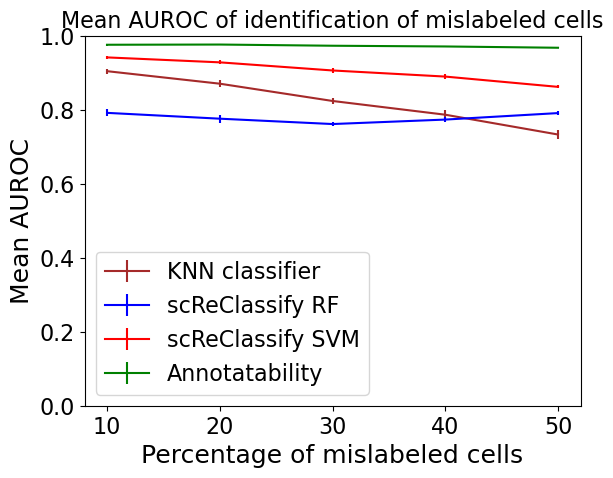

In [10]:
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_knn,
             yerr=np.sqrt(np.array(screc_res_list_knn_var)), color='brown',label='KNN classifier')
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_rf,
             yerr=np.sqrt(np.array(screc_res_list_rf_var)), color='b',label='scReClassify RF')
plt.errorbar(np.arange(1,6)*0.1*100, screc_res_list_svm,
             yerr=np.sqrt(np.array(screc_res_list_svm_var)), color='r',label='scReClassify SVM')
plt.errorbar(np.arange(1,6)*0.1*100, cell_anno_list,
             yerr=np.sqrt(np.array(cell_anno_list_var)), color='g',label='Annotatability')
plt.ylim([0,1])
plt.title("Mean AUROC of identification of mislabeled cells", fontsize=16)
plt.xlabel("Percentage of mislabeled cells", fontsize=18)
plt.ylabel("Mean AUROC", fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [11]:
print(screc_res_list_knn)
print()
print(screc_res_list_rf)
print()
print(screc_res_list_svm)
print()
print(cell_anno_list)

[0.9051537701462582, 0.8712872335780977, 0.8245615024833803, 0.787381759297505, 0.7337801954944552]

[0.7923709283367968, 0.7766136863331528, 0.7621207165027334, 0.7742015680820847, 0.7917563752304674]

[0.9424116027636428, 0.9290492244846554, 0.9070731416977733, 0.8905417847512714, 0.8627068270423436]

[0.9766568917971068, 0.9772143382603542, 0.9739845798793105, 0.9720132413679158, 0.9685385753148029]


In [12]:
print(screc_res_list_rf_var)
print()
print(screc_res_list_svm_var)
print()
print(cell_anno_list_var)
print()
print(screc_res_list_knn_var)

[9.030227667260086e-05, 0.00012722872183541014, 3.000036790189461e-05, 4.853315247293475e-05, 2.0583521155843886e-05]

[2.080304138163185e-05, 3.3356229087711383e-05, 3.3149875642299674e-05, 3.543725989480136e-05, 1.5515196441818927e-05]

[1.0908763118803508e-05, 3.3228387196660357e-06, 2.6059918146136316e-06, 3.086312728063403e-06, 3.917081127760193e-06]

[4.185406235969871e-05, 8.716297853326116e-05, 6.414948646708771e-05, 0.00014928667739779697, 0.0001516189753362007]
